***说明：本文依据《Sklearn 与 TensorFlow 机器学习实用指南》完成，所有版权和解释权均归作者和翻译成员所有，我只是搬运和做注解。***
第六章### 集成学习和随机森林
假设你去随机问很多人一个很复杂的问题，然后把它们的答案合并起来。通常情况下你会发现这个合并的答案比一个专家的答案要好。这就叫做**群体智慧**。  
如果合并一组分类器的预测（像分类或者回归），同样会得到一个比单一分类器更好的预测结果。这一组分类器就叫做集成。  
因此，这个技术就叫做**集成学习**，一个集成学习算法就叫做集成方法。  
例如，你可以训练一组决策树分类器，每一个都在一个随机的训练集上。为了去做预测，你必须得到所有单一树的预测值，然后通过投票（例如第六章的练习）来预测类别。例如一种决策树的集成就叫做随机森林，它除了简单之外也是现今存在的最强大的机器学习算法之一。  
一般会在一个项目快结束的时候使用集成算法，一旦你建立了一些好的分类器，就把他们合并为一个更好的分类器。在机器学习竞赛中获得胜利的算法经常会包含一些集成方法。  
本章中，教程讨论了几个著名的集成方法：**bagging, boosting, stacking**和其他一些算法。我们也会讨论**随机森林**。
源代码已经同步在github中  
https://github.com/jwc19890114/-02-learning-file-100days
本章中理论多过实操，所以基本上是抄了，如果不喜欢的同学可以直接看github里面的源文档。

#### 1. 投票分类
弱学习器：结果比瞎猜好一点点的学习器，准确率在51%。  
强学习器：准确率高的学习器。
如果已经训练了若干分类器（logistic、SVM、KNN等），每一个都有80%的准确率，基于这些分类器创建一个更好的分类器的方法就是**整合**每一个分类器的预测，然后经过投票预测分类。这种分类器为**硬投票分类器**。
投票分类器得出的结果通常会比集成中单一最好的结果更好，即是说每一个分类器都是一个**弱学习器**，在集成后仍然是一个强学习器。  
教程在这里举了一个掷硬币的大数定律，十次独立实验最终结果都会在51%上下浮动，看看就好。  
#### 前置准备
~~~python
import numpy as np
import os
np.random.seed(42)
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# 保存图片
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id)

def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)
~~~
#### 掷硬币
~~~python
heads_proba=0.51
coin_tosses=(np.random.rand(10000,10)<heads_proba).astype(np.int32)
cumulative_heads_ratio=np.cumsum(coin_tosses,axis=0)/np.arange(1,10001).reshape(-1,1)
plt.figure(figsize=(11,5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", linewidth=2, label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
# save_fig("law_of_large_numbers_plot")
plt.show()
~~~

同样，如果生成多搁分类器的集成模型，正确率仅为51%，如果使用投票预测的话，可能会得到一个正确率很高的学习器。前提是**所有的分类器都独立运行的很好、不会发生有相关性的错误的情况下才会这样，然而每一个分类器都在同一个数据集上训练，导致其很可能会发生这样的错误。他们可能会犯同一种错误，所以也会有很多票投给了错误类别导致集成的准确率下降**。  
下面的代码创建和训练了在sklearn中的投票分类器。这个分类器由三个不同的分类器组成**训练集是第五章中的moons数据集**，可以发现投票分类器表现要优于其他独立分类器。
~~~python
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
log_clf=LogisticRegression()
rnd_clf=RandomForestClassifier()
svm_clf=SVC()
#votingClassifier的基本思想是：组合不同的机器学习模型，通过投票或者是平均的方式预测最后的标签。
voting_clf=VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],voting='hard')
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
X,y=make_moons(n_samples=500, noise=0.30, random_state=42)
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42)
voting_clf.fit(X_train,y_train)
from sklearn.metrics import accuracy_score
for clf in (log_clf,rnd_clf,svm_clf,voting_clf):
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))
~~~
如果所有分类器都能够预测类别的概率，可以让Sklearn以最高的类概率来预测这个类，平均在所有的分类器上，这就是**软投票**，效果比硬投票好，因为给予高自信的投票更大的权重，通过将voting="hard"设置为voting="soft"来保证分类器可以预测类别概率。然而这不是 SVC 类的分类器默认的选项，所以你需要把它的probability hyperparameter设置为True。可以看到，软投票的正确率达到91%。
~~~python
log_clf=LogisticRegression(solver='liblinear',random_state=42)
rnd_clf=RandomForestClassifier(n_estimators=10,random_state=42)
svm_clf=SVC(gamma="auto",probability=True, random_state=42)
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)
from sklearn.metrics import accuracy_score
for clf in (log_clf,rnd_clf,svm_clf,voting_clf):
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))
~~~

In [6]:
import numpy as np
import os
np.random.seed(42)
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# 保存图片
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id)

def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)

In [6]:
heads_proba=0.51
coin_tosses=(np.random.rand(10000,10)<heads_proba).astype(np.int32)
cumulative_heads_ratio=np.cumsum(coin_tosses,axis=0)/np.arange(1,10001).reshape(-1,1)

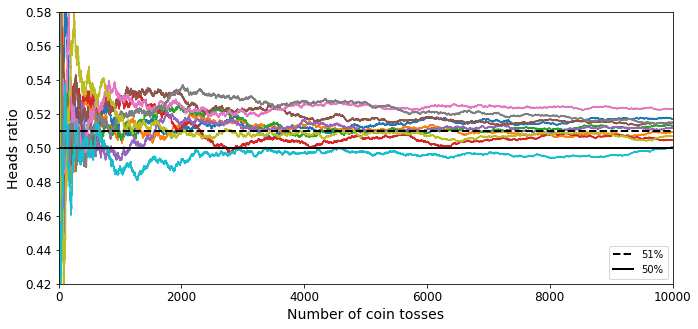

In [15]:
plt.figure(figsize=(11,5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", linewidth=2, label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
# save_fig("law_of_large_numbers_plot")
plt.show()

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
log_clf=LogisticRegression()
rnd_clf=RandomForestClassifier()
svm_clf=SVC()
#votingClassifier的基本思想是：组合不同的机器学习模型，通过投票或者是平均的方式预测最后的标签。
voting_clf=VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],voting='hard')

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
X,y=make_moons(n_samples=500, noise=0.30, random_state=42)
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42)
voting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomF...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [19]:
from sklearn.metrics import accuracy_score
for clf in (log_clf,rnd_clf,svm_clf,voting_clf):
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.888
VotingClassifier 0.896


In [20]:
log_clf=LogisticRegression(solver='liblinear',random_state=42)
rnd_clf=RandomForestClassifier(n_estimators=10,random_state=42)
svm_clf=SVC(gamma="auto",probability=True, random_state=42)
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomFor...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [21]:
from sklearn.metrics import accuracy_score
for clf in (log_clf,rnd_clf,svm_clf,voting_clf):
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


***说明：本文依据《Sklearn 与 TensorFlow 机器学习实用指南》完成，所有版权和解释权均归作者和翻译成员所有，我只是搬运和做注解。***
第六章### 集成学习和随机森林
假设你去随机问很多人一个很复杂的问题，然后把它们的答案合并起来。通常情况下你会发现这个合并的答案比一个专家的答案要好。这就叫做**群体智慧**。  
如果合并一组分类器的预测（像分类或者回归），同样会得到一个比单一分类器更好的预测结果。这一组分类器就叫做集成。  
因此，这个技术就叫做**集成学习**，一个集成学习算法就叫做集成方法。  
例如，你可以训练一组决策树分类器，每一个都在一个随机的训练集上。为了去做预测，你必须得到所有单一树的预测值，然后通过投票（例如第六章的练习）来预测类别。例如一种决策树的集成就叫做随机森林，它除了简单之外也是现今存在的最强大的机器学习算法之一。  
一般会在一个项目快结束的时候使用集成算法，一旦你建立了一些好的分类器，就把他们合并为一个更好的分类器。在机器学习竞赛中获得胜利的算法经常会包含一些集成方法。  
本章中，教程讨论了几个著名的集成方法：**bagging, boosting, stacking**和其他一些算法。我们也会讨论**随机森林**。
源代码已经同步在github中  
https://github.com/jwc19890114/-02-learning-file-100days
本章中理论多过实操，所以基本上是抄了，如果不喜欢的同学可以直接看github里面的源文档。

#### 2. Bagging 和 Pasting
投票分类器是使用不同训练算法训练同一批数据得到不同的分类器；也可以使用不同训练集处理同一个训练算法，有放回采样的称为装袋bagging，无放回采样的成为粘贴。  
通过这种在基学习器构建的过程中引入随机方法，并最后通过集成。利用这种方式来降低单个学习器的方差。最终降低过拟合。  
Bagging的方法有很多，不同的是随机选择训练数据的方式
- Pasting：随机选择数据子集
- Bagging：可以重复抽样
- Random Subspaces：样本在随机选择的属性中抽样
- Random Patches：构建基学习器的时候样本和属性都是子集时
当所有的分类器被训练后，集成可以通过对所有分类器结果的简单聚合来对新的实例进行预测。聚合函数通常对分类是**统计模式（例如硬投票分类器）或者对回归是平均**。每一个单独的分类器在如果在原始训练集上都是高偏差，但是聚合降低了偏差和方差。通常情况下，集成的结果是有一个相似的偏差，但是对比与在原始训练集上的单一分类器来讲有更小的方差。  

#### 在Sklearn中的Bagging和Pasting
sklearn为Bagging和Pasting提供了一个简单的API：**BaggingClassifier类**（对于回归可以是**BaggingRegressor**）  
接下来的代码训练一个包含有500个决策树分类器的集成，每一个都是在数据集上有放回采样100个训练实例下进行训练（这是 Bagging 的例子，如果想试试Pasting，就设置bootstrap=False）。  
n_jobs参数告诉sklearn用于训练和预测所需要CPU核的数量。（-1 代表着 sklearn 会使用所有空闲核）  
对比一下，发现pasting的正确率比bagging高一丢丢。  
~~~python
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.tree import DecisionTreeClassifier
#注意参数设置
bag_clf=BaggingClassifier(
    DecisionTreeClassifier(random_state=42),
    n_estimators=500,
    max_samples=100,
    #bootstrap=False,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
bag_clf.fit(X_train,y_train)
bag_pred=bag_clf.predict(X_test)
print(accuracy_score(y_test,bag_pred)) # 0.904/0.912
~~~
再对比一下只使用决策树的模型。  
~~~python
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))
~~~
可视化三个模型
~~~python
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
def plot_decision_boundary(clf,X,y,axes=[-1.5,2.5,-1,1.5],alpha=0.5,contour=True):
    x1s=np.linspace(axes[0],axes[1],100)
    x2s=np.linspace(axes[2],axes[3],100)
    x1,x2=np.meshgrid(x1s,x2s)
    X_new=np.c_[x1.ravel(),x2.ravel()]
    y_pred=clf.predict(X_new).reshape(x1.shape)
    custom_cmp=ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1,x2,y_pred,alpha=0.3,cmp=custom_cmp)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

plt.figure(figsize=(16,4))
plt.subplot(131)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(132)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.subplot(133)
plot_decision_boundary(bag_pasting_clf, X, y)
plt.title("Decision Trees with Pasting", fontsize=14)
plt.show()               
~~~
Bootstrap在每个预测器被训练的子集中引入了更多的分集，所以 Bagging 结束时的偏差比Pasting更高，但这也意味着预测因子最终变得不相关，从而减少了集合的方差。总体而言，Bagging 通常会导致更好的模型，这就解释了为什么它通常是首选的。  
#### Out-of-Bag评价
在Bagging中有大概37%的实例是不会被采样的，这就是out of bag实例，这部分实例可以用来做评估，从而不需要单独建立一个交叉验证集，可以将每个分类器的oob用来评估这个分类器。  
方法：在初始化BaggingClassifier时设置oob_score=True来自动评估。  
~~~python
bag_clf=BaggingClassifier(
    DecisionTreeClassifier(random_state=42),
    n_estimators=500,
    bootstrap=True,
    n_jobs=-1,
    oob_score=True,
    random_state=40
)
bag_clf.fit(X_train,y_train)
bag_clf.oob_score_
bag_clf.oob_decision_function_
y_pred=bag_clf.predict(X_test)
print(accuracy_score(y_test,y_pred))
~~~

In [25]:
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.tree import DecisionTreeClassifier
bag_clf=BaggingClassifier(
    DecisionTreeClassifier(random_state=42),
    n_estimators=500,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
bag_clf.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=100, n_estimators=500, n_jobs=-1, oob_score=False,
         random_state=42, verbose=0, warm_start=False)

In [28]:
bag_pred=bag_clf.predict(X_test)
print(accuracy_score(y_test,bag_pred))

0.904


In [33]:
bag_pasting_clf=BaggingClassifier(
    DecisionTreeClassifier(random_state=42),
    n_estimators=500,
    max_samples=100,
    bootstrap=False,
    n_jobs=-1,
    random_state=42
)
bag_pasting_clf.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
         bootstrap=False, bootstrap_features=False, max_features=1.0,
         max_samples=100, n_estimators=500, n_jobs=-1, oob_score=False,
         random_state=42, verbose=0, warm_start=False)

In [34]:
bag_pred_pasting=bag_pasting_clf.predict(X_test)
print(accuracy_score(y_test,bag_pred_pasting))

0.912


In [35]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
def plot_decision_boundary(clf,X,y,axes=[-1.5,2.5,-1,1.5],alpha=0.5,contour=True):
    x1s=np.linspace(axes[0],axes[1],100)
    x2s=np.linspace(axes[2],axes[3],100)
    x1,x2=np.meshgrid(x1s,x2s)
    X_new=np.c_[x1.ravel(),x2.ravel()]
    y_pred=clf.predict(X_new).reshape(x1.shape)
    custom_cmp=ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1,x2,y_pred,alpha=0.3,cmp=custom_cmp)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\contour.py:1004: UserWarning: The following kwargs were not used by contour: 'cmp'
  s)


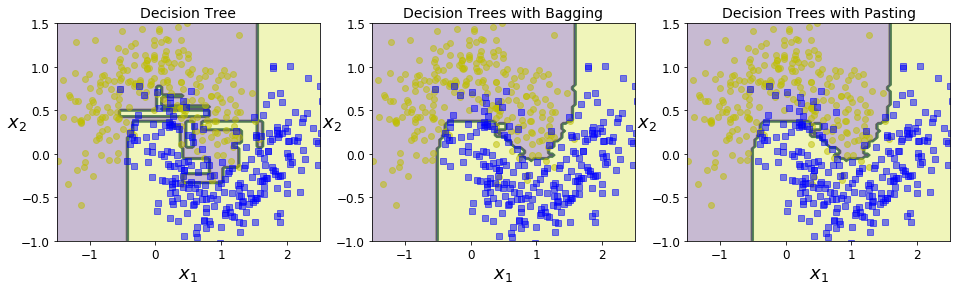

In [38]:
plt.figure(figsize=(16,4))
plt.subplot(131)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(132)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.subplot(133)
plot_decision_boundary(bag_pasting_clf, X, y)
plt.title("Decision Trees with Pasting", fontsize=14)
plt.show()

In [39]:
bag_clf=BaggingClassifier(
    DecisionTreeClassifier(random_state=42),
    n_estimators=500,
    bootstrap=True,
    n_jobs=-1,
    oob_score=True,
    random_state=40
)
bag_clf.fit(X_train,y_train)
bag_clf.oob_score_
bag_clf.oob_decision_function_
y_pred=bag_clf.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.9013333333333333

In [40]:
bag_clf.oob_decision_function_

array([[0.31746032, 0.68253968],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.08379888, 0.91620112],
       [0.31693989, 0.68306011],
       [0.02923977, 0.97076023],
       [0.97687861, 0.02312139],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.71195652, 0.28804348],
       [0.83957219, 0.16042781],
       [0.97777778, 0.02222222],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97297297, 0.02702703],
       [0.95238095, 0.04761905],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.38947368, 0.61052632],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.96685083, 0.03314917],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.64804469, 0.35195531],
       [0.

In [41]:
y_pred=bag_clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.912

***说明：本文依据《Sklearn 与 TensorFlow 机器学习实用指南》完成，所有版权和解释权均归作者和翻译成员所有，我只是搬运和做注解。***
第六章### 集成学习和随机森林
假设你去随机问很多人一个很复杂的问题，然后把它们的答案合并起来。通常情况下你会发现这个合并的答案比一个专家的答案要好。这就叫做**群体智慧**。  
如果合并一组分类器的预测（像分类或者回归），同样会得到一个比单一分类器更好的预测结果。这一组分类器就叫做集成。  
因此，这个技术就叫做**集成学习**，一个集成学习算法就叫做集成方法。  
例如，你可以训练一组决策树分类器，每一个都在一个随机的训练集上。为了去做预测，你必须得到所有单一树的预测值，然后通过投票（例如第六章的练习）来预测类别。例如一种决策树的集成就叫做随机森林，它除了简单之外也是现今存在的最强大的机器学习算法之一。  
一般会在一个项目快结束的时候使用集成算法，一旦你建立了一些好的分类器，就把他们合并为一个更好的分类器。在机器学习竞赛中获得胜利的算法经常会包含一些集成方法。  
本章中，教程讨论了几个著名的集成方法：**bagging, boosting, stacking**和其他一些算法。我们也会讨论**随机森林**。
源代码已经同步在github中  
https://github.com/jwc19890114/-02-learning-file-100days
本章中理论多过实操，所以基本上是抄了，如果不喜欢的同学可以直接看github里面的源文档。

### 3.随机森林
随机森林是决策树的一种集成，通常使用bagging方法进行训练。  
参数设置：  
- max_samples设置训练集大小
- n_estimators设置随机森林树大小
- max_leaf_nodes设置叶子节点数
~~~python
bag_clf=BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16,random_state=42),
    n_estimators=500,
    max_samples=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
bag_clf.fit(X_train,y_train)
y_pred=bag_clf.predict(X_test)
from sklearn.ensemble import RandomForestClassifier
rnd_clf=RandomForestClassifier(n_estimators=500,max_leaf_nodes=16,n_jobs=-1,random_state=42)
rnd_clf.fit(X_train,y_train)
y_pred_rf=rnd_clf.predict(X_test)
np.sum(y_pred == y_pred_rf) / len(y_pred) # 0.976
~~~
随机森林算法在树生长时引入了额外的随机；与在节点分裂时需要找到最好分裂特征相反，它在一个随机的特征集中找最好的特征，导致了树的差异性，并且再一次用高偏差换低方差，总的来说是一个更好的模型。以下是BaggingClassifier大致相当于之前的randomforestclassifier   
~~~python
from sklearn.datasets import load_iris
iris=load_iris()
rnd_clf=RandomForestClassifier(n_estimators=500,n_jobs=-1,random_state=42)
rnd_clf.fit(iris["data"],iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name , score)
    '''
    sepal length (cm) 0.11249225099876374
    sepal width (cm) 0.023119288282510326
    petal length (cm) 0.44103046436395765
    petal width (cm) 0.4233579963547681
    '''
plt.figure(figsize=(6,4))
for i in range(15):
    tree_clf=DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.02, contour=False)

plt.show()
~~~
#### 极端随机树
教程在这里仅是介绍了一下极端随机树。  
可以使用Sklearn 的ExtraTreesClassifier来创建一个Extra-Tree分类器。API与RandomForestClassifier是相同的。很难分辨ExtraTreesClassifier和RandomForestClassifier到底哪个更好。通常情况下是通过交叉验证来比较它们（使用网格搜索调整超参数）。
#### 特征重要度
如果观察一个单一决策树，重要的特征会出现在更靠近根部（顶端）的位置，而不重要的特征会经常出现在靠近叶子的位置。  
可以通过计算一个特征在森林的全部树中出现的平均深度来预测特征的重要性。sklearn 在训练后会自动计算每个特征的重要度。可以通过**feature_importances_**变量来查看结果。例如如下代码在 iris 数据集（第四章介绍）上训练了一个RandomForestClassifier模型，然后输出了每个特征的重要性。看来，最重要的特征是花瓣长度（44%）和宽度（42%），而萼片长度和宽度相对比较是不重要的（分别为 11% 和 2%）
~~~python
rnd_clf.feature_importances_
'''
sepal length (cm) 0.11249225099876374
sepal width (cm) 0.023119288282510326
petal length (cm) 0.44103046436395765
petal width (cm) 0.4233579963547681
'''
~~~
接下来介绍了通过绘制热力图来画出每个像素的重要性。
~~~python
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1)
    mnist.target = mnist.target.astype(np.int64)
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original', data_home="./MNIST_data")

rnd_clf=RandomForestClassifier(n_estimators=10,random_state=42)
rnd_clf.fit(mnist["data"],mnist["target"])
def plot_digit(data):
    image=data.reshape(28,28)
    plt.imshow(image,cmap=mpl.cm.hot,interpolation="nearest")
    plt.axis("off")

plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()
~~~

In [42]:
bag_clf=BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16,random_state=42),
    n_estimators=500,
    max_samples=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
bag_clf.fit(X_train,y_train)
y_pred=bag_clf.predict(X_test)

In [43]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf=RandomForestClassifier(n_estimators=500,max_leaf_nodes=16,n_jobs=-1,random_state=42)
rnd_clf.fit(X_train,y_train)
y_pred_rf=rnd_clf.predict(X_test)

In [44]:
np.sum(y_pred == y_pred_rf) / len(y_pred) 

0.976

In [46]:
from sklearn.datasets import load_iris
iris=load_iris()
rnd_clf=RandomForestClassifier(n_estimators=500,n_jobs=-1,random_state=42)
rnd_clf.fit(iris["data"],iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name , score)

sepal length (cm) 0.11249225099876374
sepal width (cm) 0.023119288282510326
petal length (cm) 0.44103046436395765
petal width (cm) 0.4233579963547681


In [47]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\contour.py:1004: UserWarning: The following kwargs were not used by contour: 'cmp'
  s)


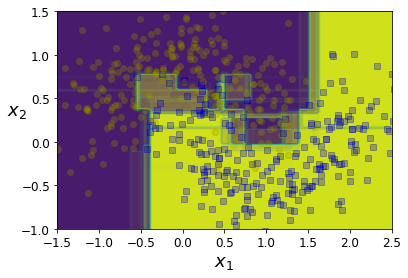

In [49]:
plt.figure(figsize=(6,4))
for i in range(15):
    tree_clf=DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.02, contour=False)

plt.show()

In [56]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_745', version=1)
    mnist.target = mnist.target.astype(np.int64)
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original', data_home="./MNIST_data")

In [57]:
rnd_clf=RandomForestClassifier(n_estimators=10,random_state=42)
rnd_clf.fit(mnist["data"],mnist["target"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [58]:
def plot_digit(data):
    image=data.reshape(28,28)
    plt.imshow(image,cmap=mpl.cm.hot,interpolation="nearest")
    plt.axis("off")

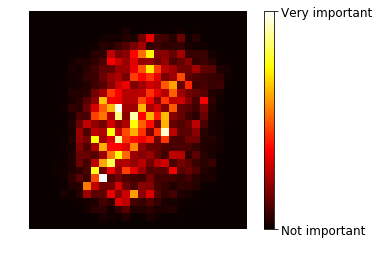

In [59]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

***说明：本文依据《Sklearn 与 TensorFlow 机器学习实用指南》完成，所有版权和解释权均归作者和翻译成员所有，我只是搬运和做注解。***
第六章### 集成学习和随机森林
假设你去随机问很多人一个很复杂的问题，然后把它们的答案合并起来。通常情况下你会发现这个合并的答案比一个专家的答案要好。这就叫做**群体智慧**。  
如果合并一组分类器的预测（像分类或者回归），同样会得到一个比单一分类器更好的预测结果。这一组分类器就叫做集成。  
因此，这个技术就叫做**集成学习**，一个集成学习算法就叫做集成方法。  
例如，你可以训练一组决策树分类器，每一个都在一个随机的训练集上。为了去做预测，你必须得到所有单一树的预测值，然后通过投票（例如第六章的练习）来预测类别。例如一种决策树的集成就叫做随机森林，它除了简单之外也是现今存在的最强大的机器学习算法之一。  
一般会在一个项目快结束的时候使用集成算法，一旦你建立了一些好的分类器，就把他们合并为一个更好的分类器。在机器学习竞赛中获得胜利的算法经常会包含一些集成方法。  
本章中，教程讨论了几个著名的集成方法：**bagging, boosting, stacking**和其他一些算法。我们也会讨论**随机森林**。
源代码已经同步在github中  
https://github.com/jwc19890114/-02-learning-file-100days
本章中理论多过实操，所以基本上是抄了，如果不喜欢的同学可以直接看github里面的源文档。

### 4.提升（boosting，假设增强）
指的是可以将几个弱学习器组合成强学习器的集成方法。对于大多数的提升方法的思想就是**按顺序去训练分类器**，每一个都要尝试修正前面的分类。现如今已经有很多的提升方法了，但最著名的就是 **Adaboost（适应性提升，是 Adaptive Boosting 的简称）**和**Gradient Boosting（梯度提升）**。  
#### Adaboost适应性提升
使一个新的分类器去修正之前分类结果的方法就是对**之前分类结果不对的训练实例多加关注**。这导致新的预测因子越来越多地聚焦于这种情况。这是Adaboost使用的技术。  
举个例子，去构建一个 Adaboost 分类器，第一个基分类器（例如一个决策树）被训练然后在训练集上做预测，在误分类训练实例上的权重就增加了。第二个分类机使用更新过的权重然后再一次训练，权重更新，以此类推。  

下图左侧第一个分类器误分类了很多实例，所以它们的权重被提升了。第二个分类器因此对这些误分类的实例分类效果更好，以此类推。右侧图代表了除了学习率减半外（误分类实例权重每次迭代上升一半）相同的预测序列。可以看出，序列学习技术与梯度下降很相似，除了调整单个预测因子的参数以最小化代价函数之外，AdaBoost增加了集合的预测器，逐渐使其更好。
一旦所有的分类器都被训练后，除了分类器根据整个训练集上的准确率被赋予的权重外，集成预测就非常像Bagging和Pasting了。
**序列学习技术的一个重要的缺点**就是：它不能被并行化（只能按步骤），因为每个分类器只能在之前的分类器已经被训练和评价后再进行训练。因此，它不像Bagging和Pasting一样。
让我们详细看一下 Adaboost 算法。每一个实例的权重wi初始都被设为1/m第一个分类器被训练，然后他的权重误差率r1在训练集上算出。

公式

~~~python
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.svm import SVC

X,y=make_moons(n_samples=500, noise=0.30, random_state=42)
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42)

m=len(X_train)
plt.figure(figsize=(11,4))
#这是一个生成多个图形的示例
for subplot ,learning_rate in ((121,1),(122,0.5)):
    sample_weights=np.ones(m)
    plt.subplot(subplot)
    for i in range(5):
        #每一个分类器都是高度正则化带有RBF核的SVM
        svm_clf=SVC(kernel="rbf",C=0.05,gamma="auto",random_state=42)
        svm_clf.fit(X_train,y_train,sample_weight=sample_weights)
        y_pred=svm_clf.predict(X_train)
        sample_weights[y_pred !=y_train]*=(1+learning_rate)
        plot_decision_boundary(svm_clf, X,y,alpha=0.2)
    if subplot == 121:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)

plt.show()
        
~~~
sklearn 通常使用Adaboost的多分类版本SAMME。如果只有两类别，那么SAMME是与Adaboost相同的。  
接下来的代码训练了使用 sklearn 的AdaBoostClassifier基于 200 个决策树的Adaboost分类器（正如你说期待的，对于回归也有AdaBoostRegressor）。一个决策树是max_depth=1的决策树-换句话说，是一个单一的决策节点加上两个叶子结点。这就是AdaBoostClassifier的默认基分类器
~~~python
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
ada_clf=AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200,
    algorithm="SAMME.R",
    learning_rate=0.5,
    random_state=42
)
ada_clf.fit(X_train,y_train)
plot_decision_boundary(ada_clf,X,y)
~~~

#### 梯度提升
梯度提升是另一种提升算法，和Adaboost一样通过向集成中增加分类器运行，每一个分类器都在修正之前的分类结果。然而，它并不像 Adaboost那样每一次迭代都更改实例的权重，这个方法是去使用新的分类器去拟合前面分类器预测的残差。  
教程中通过一个使用决策树当做基分类器的简单的回归例子。这被叫做梯度提升回归树（GBRT，Gradient Tree Boosting 或者 Gradient Boosted Regression Trees）。  
数据准备
~~~python
np.random.seed(42)
X=np.random.rand(100,1)-0.5
y=3*X[:,0]**2+0.05*np.random.randn(100)
~~~
- 用DecisionTreeRegressor去拟合训练集（例如一个有噪二次训练集）
~~~python
from sklearn.tree import DecisionTreeRegressor
tree_reg1=DecisionTreeRegressor(max_depth=1,random_state=42)
tree_reg1.fit(X,y)
~~~
- 在第一个分类器的残差上训练第二个分类器，第三个分类器同样
~~~python
y2=y-tree_reg1.predict(X)
tree_reg2=DecisionTreeRegressor(max_depth=1,random_state=42)
tree_reg2.fit(X,y2)

y3=y2-tree_reg2.predict(X)
tree_reg3=DecisionTreeRegressor(max_depth=1,random_state=42)
tree_reg3.fit(X,y3)
~~~
- 现在生成了一个包含三个回归器的集成。它可以通过集成所有树的预测来在一个新的实例上进行预测
~~~python
X_new=np.array([[0.8]])
y_pred=sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
print(y_pred) # array([0.51668536])
~~~
可视化如下图，左栏展示这三个决策树的预测，在右栏展示了集成的预测。在第一行，集成只有一个树，所以它与第一个树的预测相似。在第二行，一个新的树在第一个树的残差上进行训练。在右边栏可以看出集成的预测等于前两个树预测的和。相同的，在第三行另一个树在第二个数的残差上训练。你可以看到集成的预测会变的更好。
~~~python
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()
~~~

在sklearn中可以使用GradientBoostingRegressor来训练GBRT集成.
~~~python
from sklearn.ensemble import GradientBoostingRegressor
gbrt=GradientBoostingRegressor(max_depth=2,n_estimators=3,learning_rate=1.0)
gbrt.fit(X,y)
gbrt_slow=GradientBoostingRegressor(max_depth=2,n_estimators=200,learning_rate=0.1,random_state=42)
gbrt_slow.fit(X,y)
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_predictions([gbrt],X,y,axes=[-0.5,0.5,-0.1,0.8],label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)


plt.subplot(122)
plot_predictions([gbrt_slow],X,y,axes=[-0.5,0.5,-0.1,0.8],label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

plt.show()

~~~

In [7]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X,y=make_moons(n_samples=500, noise=0.30, random_state=42)
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42)
ada_clf=AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200,
    algorithm="SAMME.R",
    learning_rate=0.5,
    random_state=42
)
ada_clf.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=42)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\contour.py:1004: UserWarning: The following kwargs were not used by contour: 'cmp'
  s)


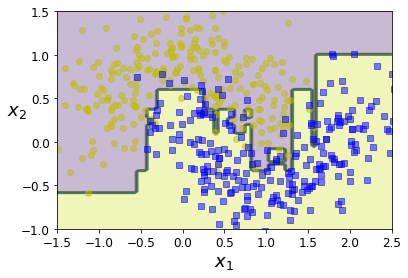

In [8]:
plot_decision_boundary(ada_clf,X,y)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\contour.py:1004: UserWarning: The following kwargs were not used by contour: 'cmp'
  s)


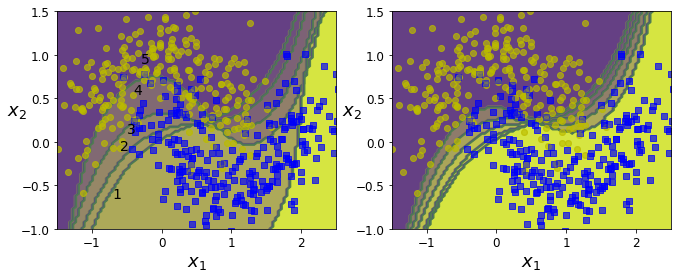

In [15]:
from sklearn.svm import SVC
m=len(X_train)
plt.figure(figsize=(11,4))
#这是一个生成多个图形的示例
for subplot ,learning_rate in ((121,1),(122,0.5)):
    sample_weights=np.ones(m)
    plt.subplot(subplot)
    for i in range(5):
        #每一个分类器都是高度正则化带有RBF核的SVM
        svm_clf=SVC(kernel="rbf",C=0.05,gamma="auto",random_state=42)
        svm_clf.fit(X_train,y_train,sample_weight=sample_weights)
        y_pred=svm_clf.predict(X_train)
        sample_weights[y_pred !=y_train]*=(1+learning_rate)
        plot_decision_boundary(svm_clf, X,y,alpha=0.2)
    if subplot == 121:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)

plt.show()
        

In [22]:
np.random.seed(42)
X=np.random.rand(100,1)-0.5
y=3*X[:,0]**2+0.05*np.random.randn(100)

In [23]:
from sklearn.tree import DecisionTreeRegressor
tree_reg1=DecisionTreeRegressor(max_depth=1,random_state=42)
tree_reg1.fit(X,y)

DecisionTreeRegressor(criterion='mse', max_depth=1, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [24]:
y2=y-tree_reg1.predict(X)
tree_reg2=DecisionTreeRegressor(max_depth=1,random_state=42)
tree_reg2.fit(X,y2)

DecisionTreeRegressor(criterion='mse', max_depth=1, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [25]:
y3=y2-tree_reg2.predict(X)
tree_reg3=DecisionTreeRegressor(max_depth=1,random_state=42)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(criterion='mse', max_depth=1, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [26]:
X_new=np.array([[0.8]])
y_pred=sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.51668536])

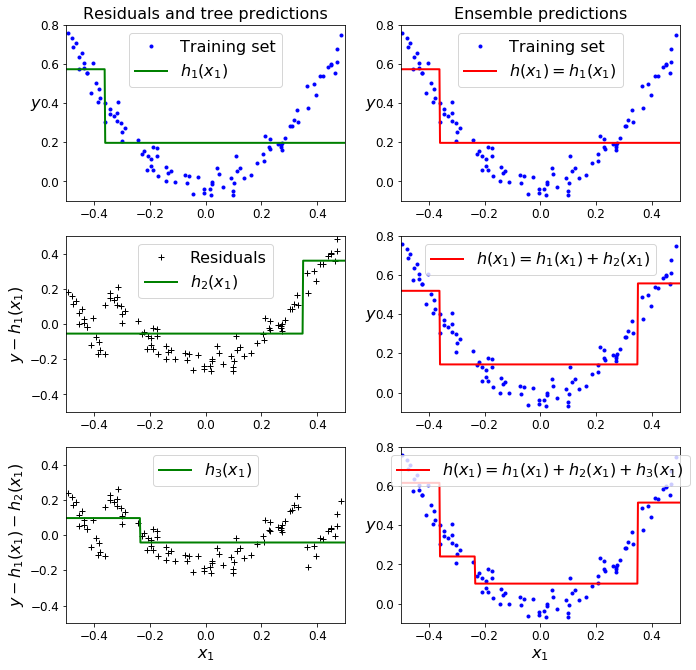

In [28]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

In [31]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt=GradientBoostingRegressor(max_depth=2,n_estimators=3,learning_rate=1.0)
gbrt.fit(X,y)
gbrt_slow=GradientBoostingRegressor(max_depth=2,n_estimators=200,learning_rate=0.1,random_state=42)
gbrt_slow.fit(X,y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

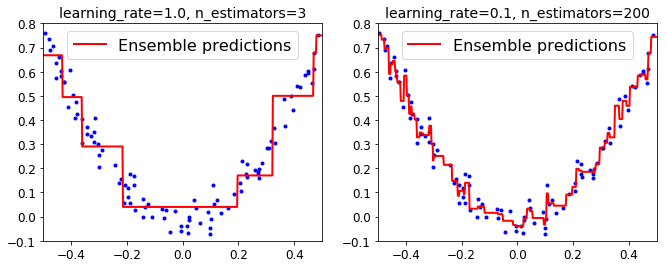

In [35]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_predictions([gbrt],X,y,axes=[-0.5,0.5,-0.1,0.8],label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)


plt.subplot(122)
plot_predictions([gbrt_slow],X,y,axes=[-0.5,0.5,-0.1,0.8],label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

plt.show()
